Aaron's advice for storing whole cell data: 

instead of treating each aquisition separately, concatenate them into a single 1-dimensional array, and use the start time to separate them into epochs. For the current sabatini lab notion of epochs, we would actually use epoch series to group together groups of traces. 

This would then make it easier to lump together individual cells into a single NWB file - each cell would correspond to a single time series which could then be added to an experiment nwb file. 

-**Nick Cain suggests this is a bad idea, b/c it would put our whole-cell data at odds w/ how the Allen institute currently does it

Alternatively, you could leave each acquisition separately, but use some timeseries that is the result of processing to link to an experiment nwb file. copy_file from HD5IO (and NWBHD5IO) see: http://pynwb.readthedocs.io/en/latest/tutorials/general/linking_data.html#sphx-glr-tutorials-general-linking-data-py

### Script to bulk convert a single whole-cell recording to an NWB file

#### Sabatini lab data format to export from
###### .mat files included for each cell:
1. AD#_# - a single acquisition, includes a 1xn data vector, plus associated metadata. First # indicates which channel. AD0 = channel 1, AD1 = channel 2. Can Also include AD2,3 for alternate inputs. For example, I often have AD2 be a copy of the voltage command from the amplifier to the headstage. The second # referes to acquisition number
    1. x,y, and z scale. x-scale is samplign rate, usually    0.1 ms
    2. UserData. Includes .mat name (e.g. 'AD0_1') and a long header string. Important paramters include:
        1. epoch #
        2. epoch name (typically empty)
        3. basename for the cell (e.g. AG013018_1)
        4. Pulse and Cycle name
        5. Input and output rate (10000)
        6. Gain
        7. Cell paramters (Vm, Im, Rm, Rs, Cm
        8. Break-in time (HH:MM::SS)
        9. Start time of the acquisition (e.g. 0.166 minutes)
        10. Flag for current clamp (0 is voltage clamp, 1 is current clamp)
2. AD#_e#p#avg - an average of each epoch and pulse (e.g. AD0_e1p1avg). Same as a single acquisition, but also includes a .nComponents and .Components in the UserData, to indicate which acquisitions are included in each epoch
3. physAcqTrace - just a list of the number of acquisitions
4. physAcqTime - simple vector of the time in minutes corresponding to each acquisition
5. A number of physCell .mat files corresponding to cell paramteres. e.g. physCellCm0, physCellRm0, etc...

#### Corresponding nwb file groups:
1. AD0_# or AD1_# ===> a single acquisition for each channel.
2. AD2_# or AD3_# (or higher) ==> a single stimulus for each acquisition. May not be included in each cell
2. AD#_e#p#avg ==> either analysis or processing, but also useful for extracting epoch information
3. physAcqTrace ==> I think largely redundant, easy to extract total # of acqusitions
4. physAcqTime ==> Time-series to constitute or recreate the timing between sweeps
5. physCell parameters ==> processing

In [1]:
# Import python libraries
import os
import scipy.io as sio
from datetime import datetime
from pynwb import NWBFile
from pynwb.icephys import VoltageClampSeries
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Set directory for a cell
## TO DO - user browse to folder that contains the .mat files for that cell
cwd = os.getcwd()
file_dir = cwd + '\\Example data\\Voltage clamp\\Endothelial cell voltage ramps\\013018_3\\'

In [5]:
# Get a list of all .mat files --> Do I actually need this? May be useful to keep track of which acquisitions have been loaded
mats_list = []
files = os.listdir(file_dir)
for file in files:
    if file.endswith('.mat'):
        mats_list.append(file)

In [6]:
# Extract the basename
##TO DO - load the temp_trace from the 1st .mat file, not AD0_1, since not all cells might have an AD0_1

# load in physAcqTime and a dummy trace
physAcqTime = sio.loadmat(file_dir+'physAcqTime.mat')['physAcqTime'][0] #get out a clean list of the acqusition times
temp_trace = sio.loadmat(file_dir+'AD0_1.mat',struct_as_record = False)['AD0_1']

# Get the header String - consider parsing this and converting to a dict. Each key starts w/ 'state', separated from value by '='
headerString = temp_trace[0,0].UserData[0,0].headerString[0]

#Extract the basename from headerstring - change this in the future to parse headerString as a dictionary
ind_start = headerString.index('state.files.baseName')+22
ind_finish = headerString[ind_start::].index("'")
basename = headerString[ind_start:ind_start+ind_finish]
print(basename)

AG013018_2


In [7]:
# Create the NWB file 
## TO DO: extract the type of recording from the header string, for now just assume it's a voltage clamp trace
nwbfile = NWBFile('source','session_description', basename, datetime.now(),
                  #experimenter='Dr. Bilbo Baggins',
                  #lab='Bag End Laboratory',
                  #institution='University of Middle Earth at the Shire',
                  #experiment_description='I went on an adventure with thirteen dwarves to reclaim vast treasures.',
                  #session_id='LONELYMTN'
                  )

In [8]:
#Need to create device and electrode objects first - what is the purpose of these?

#Create the device
device = nwbfile.create_device(name='Axo patch 200b',source='a source')

# Create an ic electrode object - why is this necessary?
elec = nwbfile.create_ic_electrode(
    name="elec0", source='', slice='', resistance='', seal='', description='',
    location='', filtering='', initial_access_resistance='', device=device.name)

In [9]:
#Load in each acquisiion to the nwbfile
acq_num = len(physAcqTime) #Get the number of acquisitions to load in

#Start with just AD0 for now, add in AD1 option later - or maybe loop through all .mat files, and parse them to determine if they
#go to acquisition of processing?
for i in range(acq_num):
    mat_name = 'AD0_' + str(i+1)
    tmp = file_dir+mat_name+'.mat'
    
    #load in the acquisition structure
    acq = sio.loadmat(file_dir+mat_name+'.mat',struct_as_record = False)[mat_name]
    
    # Create the voltage clamp series object
    vcs = VoltageClampSeries(name=mat_name, 
                             source="AG", 
                             data=acq[0,0].data[0],
                             unit='pA', 
                             conversion=1.0, 
                             resolution=np.nan, 
                             starting_time=physAcqTime[i], 
                             rate=1e4,
                             electrode=elec,
                             gain=np.nan,
                             capacitance_slow=np.nan,
                             resistance_comp_correction=np.nan,
                             capacitance_fast=np.nan,
                             resistance_comp_bandwidth=np.nan,
                             resistance_comp_prediction=np.nan,
                             whole_cell_capacitance_comp=np.nan,
                             whole_cell_series_resistance_comp=np.nan
                            )

    # Add the voltage clamp series object to the nwbfile
    nwbfile.add_acquisition(vcs)
    
    

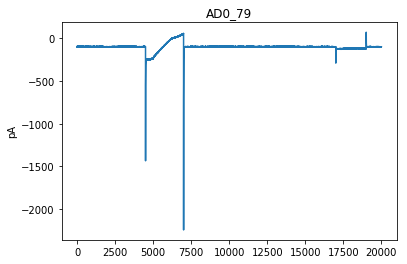

In [11]:
#testing that all acquisitions are saved
import matplotlib.pyplot as plt
vcs_out = nwbfile.get_acquisition('AD0_79')

plt.plot(vcs_out.data)
plt.title(vcs_out.name)
plt.ylabel(vcs_out.unit)

plt.show()

In [9]:
##TO DO: load in the epoch averages
## extract the epoch info to NWB format
## add in the physCell parameter traces

In [12]:
# Write HDF5 file
from pynwb import NWBHDF5IO

with NWBHDF5IO(basename, mode='w') as io:
    io.write(nwbfile)